# Model Training

Importing required packages ..

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import cv2
from PIL import Image
from IPython.display import clear_output
from IPython.display import Image as IPImage
from zipfile import ZipFile

Extracting training images from a zip file. I've used ffmpeg to split a video into frames. The annotated frames are organized in two folders named as 'play' or 'noplay'. These will act as labels for our data

In [ ]:
training_zip = 'ashes1edgestraining.zip'

with ZipFile(training_zip, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()    

Data is loaded from the above zip file. 20% of the training data is held for validation. Since we'll be using resnet-50 for transfer learning, it requires an input image to be of size 224x224

In [ ]:
data_dir = 'ashes1edgestraining/'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize([224, 224]),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize([224, 224]),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

This was run on a GPU machine. But the code works fine even on a CPU but it takes lot longer. We're importing ResNet-50 model weights. It was pre-trained on the ImageNet dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
#print(model)
#print(device)

We're are freezing model weights of ResNet-50 and adding two fully connected layers at the end. These layers are of sizes 2048 and 512 respectively. ReLu and Dropout regularization are applied in between to do non-linear transformation and avoid overfitting respectively. The result is into a softmax function for predicting the labels. Adam optimizer is used for training with a learning rate of 0.003. 

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

Model is trained for 5 epochs and the trained weights are saved at the end for re-use. You can see the training progress below

In [ ]:
epochs = 5
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        try:
            steps = steps+ 1
            inputs= inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in testloader:
                        inputs, labels = inputs.to(device),labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()

                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))                    
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(testloader):.3f}")
                running_loss = 0
                model.train()
        except:
            pass
torch.save(model,'ashesmodel.pth')

Graph showing how the loss was minimized with no. of epochs ..

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Extracting another random dataset to test our model

In [3]:
with ZipFile('ashes2edgestraining.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

The test images needs to go through the same transformations like training images. Below you can see functions which fetch a random sample of data and predict labels for given image

In [7]:
test_transforms = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor(),
                                     ])
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    inp = Variable(image_tensor)
    inp = inp.to(device)
    outp = model(inp)
    index = outp.data.cpu().numpy().argmax()
    return index

In [5]:
data_dir= 'ashes2edgestraining/'
data = datasets.ImageFolder(data_dir, transform=test_transforms)

Loading the pre-trained model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('cricket1.pth')
model.eval()

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Predicting the labels for randomly selected images

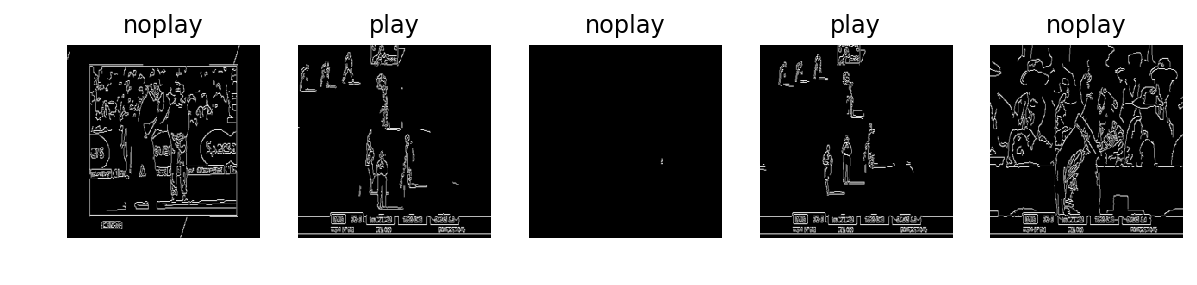

In [12]:
data = datasets.ImageFolder(data_dir, transform=test_transforms)
classes = data.classes
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
    
plt.show()